In [10]:
import pandas as pd
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import scale
from sklearn.ensemble import RandomForestRegressor
import gc
import sys
from pprint import pprint

#df_13 = pd.read_csv('13_clean.csv')
#df_13.head()

years = ['85', '87', '89', '91', '93', '95', '97', '99', '01', '03', '05', '07', '09', '11', '13']
years_num = [1985, 1987, 1989, 1991, 1993, 1995, 1997, 1999, 2001, 2003, 2005, 2007, 2009, 2011, 2013 ]


def combineDataFrame(years, years_num):
    
    df_allYears = pd.DataFrame()
    
    for year, i in zip(years, years_num):
        df = pd.read_csv(year + '_clean.csv')
        df['YEAR'] = i
        df_allYears = df_allYears.append(df)
    
    return df_allYears
    
df_allYears = combineDataFrame(years, years_num)

#Keep only LMED from above set since 'ABL50', 'ABL80', 'ABLMED', 'GL50', 'GL80', 'GLMED', 'L50' are correlated
cols = ['ABL50', 'ABL80', 'ABLMED', 'GL50', 'GL80', 'GLMED', 'L50']
df_allYears.drop(cols, axis=1, inplace=True)


#Keep only 'INCRELAMIPCT' from above set since 'ZINC2', 'TOTSAL' are correlated
cols = ['ZINC2', 'TOTSAL']
df_allYears.drop(cols, axis=1, inplace=True)

#choose columns that are independent, e.g. COSTMED, COSTMEDRELAMITPCT, FMTCOSTMEDRELAMIPCT 
#show the same data in different format; ditto for FMTINCRELAMICAT and INCRELAMIPCT
# drop CONTROL as well
cols = ['CONTROL', 'COSTMED', 'FMTCOSTMEDRELAMICAT', 'FMTINCRELAMICAT']
df_allYears.drop(cols, axis=1, inplace=True)
print(df_allYears.shape)

#removing columns related to cost since these are related to target variable ZSMHC (monthly housing cost)
cols = ['COSTMEDRELAMIPCT', 'BURDEN', 'OTHERCOST', 'UTILITY']
df_allYears.drop(cols, axis=1, inplace=True)
print(df_allYears.shape)

#drop na values
df_allYears = df_allYears.dropna()
print(df_allYears.shape)

#remove values of FMTMETRO set to 9;
df_allYears = df_allYears.loc[~df_allYears['FMTMETRO'].str.contains('9', regex=False)]


#drop FMTSTATUS - earlier generated ill-defined matrix warning for ridge regression;
#values for this column is constanct for several years
df_allYears.drop('FMTSTATUS', axis=1, inplace=True)

#converting REGION from int type to string type
df_allYears['REGION'].apply(str)

#convert categorical variables to indicator variables
df_allYears = pd.get_dummies(df_allYears, drop_first=True)

print(df_allYears.columns)

(771870, 24)
(771870, 20)
(486785, 20)
Index(['AGE', 'BEDRMS', 'FMR', 'INCRELAMIPCT', 'IPOV', 'LMED', 'NUNITS', 'PER',
       'ROOMS', 'VALUE', 'ZSMHC', 'REGION', 'YEAR', 'FMTBUILT_'1960-1979'',
       'FMTBUILT_'1980-1989'', 'FMTBUILT_'1990-1999'', 'FMTBUILT_'2000-2009'',
       'FMTBUILT_'After 2010'', 'FMTBUILT_'not_defined'',
       'FMTASSISTED_'0 Not Assisted'', 'FMTSTRUCTURETYPE_'2 2-4 units'',
       'FMTSTRUCTURETYPE_'3 5-19 units'', 'FMTSTRUCTURETYPE_'4 20-49 units'',
       'FMTSTRUCTURETYPE_'5 50+ units'', 'FMTSTRUCTURETYPE_'6 Mobile Home'',
       'FMTMETRO_'Central City'', 'FMTZADEQ_'2 Moderately Inadequ'',
       'FMTZADEQ_'3 Severely Indadequa''],
      dtype='object')


In [11]:
years = [1985, 1987, 1989, 1991, 1993, 1995, 1997, 1999, 2001, 2003, 2005, 2007, 2009, 2011, 2013]

quantiles = {}
for year in years:
    quantiles[year] = df_allYears.loc[df_allYears['YEAR'] == year, 'ZSMHC'].quantile(0.9)

df_allYears['QUANTILE'] = df_allYears['YEAR']
df_allYears.replace({'QUANTILE':quantiles})

df_allYears['IS_TOP_10'] = df_allYears['ZSMHC'] >= df_allYears['QUANTILE']

df_allYears['IS_TOP_10'] = df_allYears['IS_TOP_10'].apply(int)

df_allYears = df_allYears.drop(['QUANTILE', 'ZSMHC'], axis=1)

cols = list(df_allYears.drop(['IS_TOP_10'], axis=1).columns)

In [5]:
X = df_allYears.drop(['IS_TOP_10'], axis=1).values

y = df_allYears['IS_TOP_10'].values

del df_allYears

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

X_train_scaled = scale(X_train)
#y_train_scaled = scale(y_train)

X_test_scaled = scale(X_test)
#y_test_scaled = scale(y_test)

from sklearn import svm

clf = svm.SVC(random_state=42)
clf.fit(X_train_scaled, y_train)

score = clf.score(X_test_scaled, y_test)

print('score = ', score)

score =  0.9251833204145888


In [6]:
from sklearn import metrics

y_pred = clf.predict(X_test_scaled)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))


Accuracy: 0.9251833204145888
Precision: 0.7472385428907168
Recall: 0.42070790605358915


In [7]:
metrics.confusion_matrix(y_test,y_pred)

array([[128517,   2151],
       [  8756,   6359]])

/home/roberto/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


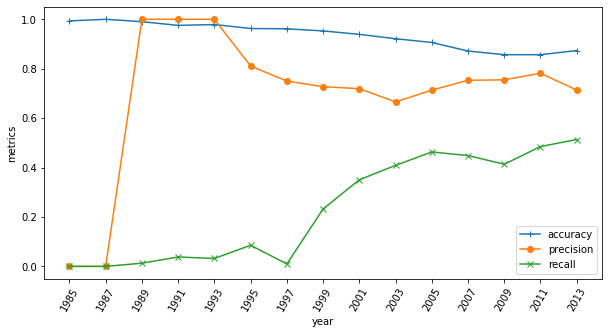

In [13]:
year_array = X_test[:,cols.index('YEAR')]

accuracies = []
precisions = []
recalls = []

#accuracy is sum of true positive and true negatives divide by total number of observations
#precision is true positive divided by total predicted positive values
#recall is true positive divided by total actual positive values

for year in years:
    y_test_year = y_test[year_array == year]
    y_pred_year = y_pred[year_array == year]
    #print(np.sum(year_array == year))
    accuracies.append(metrics.accuracy_score(y_test_year, y_pred_year))
    precisions.append(metrics.precision_score(y_test_year, y_pred_year))
    recalls.append(metrics.recall_score(y_test_year, y_pred_year))

plt.figure(figsize=(10,5))
plt.plot(years, accuracies, label='accuracy', marker = '+')
plt.plot(years, precisions, label='precision', marker = 'o')
plt.plot(years, recalls, label='recall', marker = 'x')
plt.xticks(years, years, rotation=60)
plt.xlabel('year')
plt.ylabel('metrics')
plt.legend()
plt.show()

In [14]:
for year in [1985, 1987]:
    y_test_year = y_test[year_array == year]
    y_pred_year = y_pred[year_array == year]
    print(metrics.confusion_matrix(y_test_year, y_pred_year))    

[[7550    0]
 [  50    0]]
[[7993    0]
 [   1    0]]


Because the second column of confusion matrix consists of zeroes, the model does not predict any positive values for years 1985 and 1987. Therfore the precision is undefined and set to zero in the plot above.